# Are Amazon product reviews generally more positive/negative for certain categories compared to others?

In [2]:
import pyspark.pandas as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, count, col, coalesce, lit, avg
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql import SparkSession
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Not in Requirements, poetry add vaderSentiment

data = ps.read_parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
# data = ps.read_parquet('/data/data_sample.parquet', index_col=['reviewerID', 'asin'])
print(data.shape)

/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/18 18:49:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


(230139802, 25)


The following cell creates a dataframe for all reviews that are verified and a dataframe for all reviews that are not verified. This allows the subsequent plots to visualize and compare possible differences between the two groups.

In [3]:
# data_verified = data[data['verified'] == True]
# data_not_verified = data[data['verified'] == False]

## Star Ratings

In [4]:
##
## Groups by Category and counts the number of ratings per Star Rating
## Returned Columns: 'category', 'stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5', 'number_of_reviews', 'average_rating'
##
def reduce_to_cat_stars(data):
    long_df = data.groupby(['category', 'overall']).size().reset_index(name='count')
    wide_df = long_df.pivot(index='category', columns='overall', values='count')
    wide_df.columns = [f'stars_{col}'[:-2] for col in wide_df.columns]
    wide_df = wide_df.fillna(0)

    df_cat_stars = wide_df.reset_index()
    df_cat_stars = df_cat_stars.sort_values(by=['category']).reset_index(drop=True)
    df_cat_stars = df_cat_stars.assign(number_of_reviews=lambda x: x['stars_1'] + x['stars_2'] + x['stars_3'] + x['stars_4'] + x['stars_5'])
    df_cat_stars = df_cat_stars.assign(average_rating=lambda x: (x['stars_1'] + x['stars_2']*2 + x['stars_3']*3 + x['stars_4']*4 + x['stars_5']*5) / x['number_of_reviews'])

    return df_cat_stars

data_cat_stars = reduce_to_cat_stars(data)
# ver_cat_stars = reduce_to_cat_stars(data_verified)
# notver_cat_stars = reduce_to_cat_stars(data_not_verified)


24/01/18 18:50:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


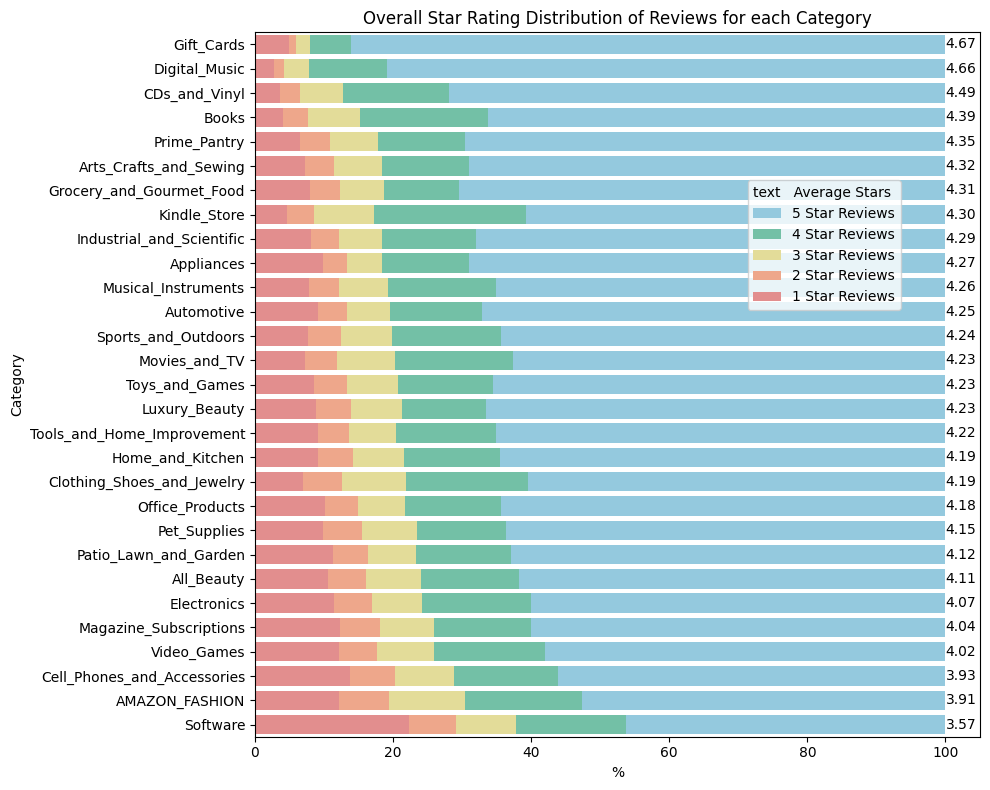

In [5]:
def plot_cat_stars(df_cat_stars):
    # Calculate comulative values
    com_df_cat_stars = df_cat_stars.copy()
    for i in range(1, 5):
        com_df_cat_stars[f'stars_{i+1}'] += com_df_cat_stars[f'stars_{i}']
    # Normalize and convert to Percent
    for i in range(1, 6):
        com_df_cat_stars[f'stars_{i}'] *= 100 / com_df_cat_stars[f'stars_5']


    pd_com_df_cat_stars = com_df_cat_stars.to_pandas()
    pd_com_df_cat_stars = pd_com_df_cat_stars.sort_values(by=['average_rating'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='stars_5', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[0], label='5 Star Reviews')
    sns.barplot(x='stars_4', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[1], label='4 Star Reviews')
    sns.barplot(x='stars_3', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[2], label='3 Star Reviews')
    sns.barplot(x='stars_2', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[3], label='2 Star Reviews')
    sns.barplot(x='stars_1', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[4], label='1 Star Reviews')

    # Annotate each bar with the corresponding average rating value
    for i, row in pd_com_df_cat_stars.iterrows():
        ax1.text(row['stars_5'], i, f'{row["average_rating"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title('Overall Star Rating Distribution of Reviews for each Category')

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text   Average Stars', alignment='left')

    # Show the plot
    plt.show()

plot_cat_stars(data_cat_stars)
# plot_cat_stars(ver_cat_stars)
# plot_cat_stars(notver_cat_stars)

## Subsample Dataset for Sentiment Analysis
For each category a sample is picked that tries to follow the distribution of the star-ratings.

In [6]:
categories = data['category'].drop_duplicates().reset_index(drop=True).to_pandas()

/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [7]:


##
## Calulates the distribution of Star Ratings for each Category and picks equally sized samples for each Category, each following the aforementioned distribution
##
def sample_for_sentiment(file_name):
    mode = 'w'
    for category in categories:
        print(f"Currently subsampling category {category} ...")
        rows_for_category = ps.read_parquet(f'/data/{category}.parquet', index_col=['reviewerID', 'asin'])
        rows_for_category = rows_for_category[['category', 'overall', 'verified', 'summary', 'reviewText']].dropna()
        # frac = 10000 / len(rows_for_category) # n samples per category
        frac = 0.01
        if frac >= 1:
            rows_for_category.to_parquet(file_name, mode=mode, index_col=['reviewerID', 'asin'])
            mode = 'a'
        else:
            for stars in range(1, 6):
                rows_for_category_and_rating = rows_for_category[rows_for_category['overall'] == stars]
                if not rows_for_category_and_rating.empty:
                    sampled_rows = rows_for_category_and_rating.sample(frac = frac, replace=False, random_state=42)
                    sampled_rows.to_parquet(file_name, mode=mode, index_col=['reviewerID', 'asin'])
                    mode = 'a'

spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "6g").config("spark.executor.memory", "6g").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","12g").getOrCreate()
sample_for_sentiment('/data/data_sample_one_percent.parquet')

print("Reading from file...")
data_sample = ps.read_parquet('/data/data_sample_one_percent.parquet', index_col=['reviewerID', 'asin'])
print(data_sample.shape)

24/01/18 18:50:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Currently subsampling category AMAZON_FASHION ...
Currently subsampling category All_Beauty ...
Currently subsampling category Appliances ...
Currently subsampling category Arts_Crafts_and_Sewing ...


Currently subsampling category Automotive ...


Currently subsampling category Books ...


Currently subsampling category CDs_and_Vinyl ...


Currently subsampling category Cell_Phones_and_Accessories ...


Currently subsampling category Clothing_Shoes_and_Jewelry ...


Currently subsampling category Digital_Music ...


Currently subsampling category Electronics ...


Currently subsampling category Gift_Cards ...
Currently subsampling category Grocery_and_Gourmet_Food ...


Currently subsampling category Home_and_Kitchen ...


Currently subsampling category Industrial_and_Scientific ...


Currently subsampling category Kindle_Store ...


Currently subsampling category Luxury_Beauty ...
Currently subsampling category Magazine_Subscriptions ...
Currently subsampling category Movies_and_TV ...


Currently subsampling category Musical_Instruments ...


Currently subsampling category Office_Products ...


Currently subsampling category Patio_Lawn_and_Garden ...


Currently subsampling category Pet_Supplies ...


Currently subsampling category Prime_Pantry ...
Currently subsampling category Software ...
Currently subsampling category Sports_and_Outdoors ...


Currently subsampling category Tools_and_Home_Improvement ...


Currently subsampling category Toys_and_Games ...


Currently subsampling category Video_Games ...


Reading from file...


(2308533, 5)


In [55]:
from pyspark.sql.functions import mean, stddev, var_samp, expr

def compare_stats(data, sample):
    summary_data = data.to_spark().groupby('category').agg(
        mean('overall').alias('mean'),
        var_samp('overall').alias('var')).toPandas()

    summary_sample = data_sample.to_spark().groupby('category').agg(
        mean('overall').alias('mean'),
        var_samp('overall').alias('var')).toPandas()

    result_df = summary_data.merge(summary_sample, on='category', how='inner', suffixes=('_data', '_sample'))
    result_df['mean_diff'] = (result_df['mean_data'] - result_df['mean_sample']).abs()
    result_df['var_diff'] = (result_df['var_data'] - result_df['var_sample']).abs()
    result_df = result_df.sort_values(by=['category'], ascending=True).reset_index(drop=True)
    result_df = result_df.sort_index(axis=1)
    
    return result_df   


compare_stats(data, data_sample)

/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,category,mean_data,mean_diff,mean_sample,var_data,var_diff,var_sample
0,AMAZON_FASHION,3.906940,0.020742,3.886198,2.011517,0.013759,2.025275
1,All_Beauty,4.112093,0.025512,4.086580,1.855312,0.041927,1.897240
2,Appliances,4.274209,0.035055,4.239155,1.694155,0.044096,1.738251
3,Arts_Crafts_and_Sewing,4.317731,0.004712,4.322442,1.484252,0.008632,1.475620
4,Automotive,4.249263,0.003225,4.246038,1.663165,0.004591,1.667756
5,Books,4.393247,0.000758,4.392489,1.092884,0.001660,1.094544
6,CDs_and_Vinyl,4.489727,0.001545,4.491273,0.985187,0.002789,0.982398
7,Cell_Phones_and_Accessories,3.933553,0.003457,3.930096,2.138930,0.003643,2.142573
8,Clothing_Shoes_and_Jewelry,4.189458,0.003685,4.185773,1.517789,0.004307,1.522096
9,Digital_Music,4.660555,0.013148,4.647408,0.712389,0.034854,0.747243


## Sentiment Analysis with VaderSentiment

In [8]:
##
## Removes unnecaccary columns and adds columns for the sentiment analysis
## New Columns: 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'
##
def reduce_to_sentiment(df):
    print(f"Number of rows with empty reviewText: {len(df[df['reviewText'].isna()])}")
    print(f"Number of rows with empty summary: {len(df[df['summary'].isna()])}")
    df['text'] = df['summary'] + ' - ' + df['reviewText']
    df = df[['category', 'overall', 'verified', 'text']].dropna()  # Remove not needed rows and cols

    df = df.to_spark()

    calculate_neg_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neg'], DoubleType())
    df = df.withColumn("vader_neg", calculate_neg_score(df['text']))
    calculate_neu_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neu'], DoubleType())
    df = df.withColumn("vader_neu", calculate_neu_score(df['text']))
    calculate_pos_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['pos'], DoubleType())
    df = df.withColumn("vader_pos", calculate_pos_score(df['text']))
    calculate_compound_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'], DoubleType())
    df = df.withColumn("vader_compound", calculate_compound_score(df['text']))

    df = df[['category', 'overall', 'verified', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']]
    calculate_sentiment = udf(lambda compound: 'very_positive' if compound >= 0.75 
                                else ('positive' if compound >= 0.25 
                                else ('very_negative' if compound <= -0.75 
                                else ('negative' if compound <= -0.25
                                else 'neutral'))), StringType())
    df = df.withColumn("sentiment", calculate_sentiment(df['vader_compound']))
    return df

##
## Groups by Category and counts the number of ratings per sentiment class
## Resulting Columns: 'category', 'very_negative', 'negative', 'neutral', 'positive', 'very_positive', 'number_of_reviews', 'average_sentiment'
##
def reduce_to_cat_sentiment(df):
    long_df = df.groupBy("category", "sentiment").agg(count("*").alias("count")).toPandas()
    wide_df = long_df.pivot(index='category', columns='sentiment', values='count')
    # wide_df.columns = [f'sentiment_{col}' for col in wide_df.columns]
    wide_df = wide_df.fillna(0)

    df_cat_sentiment = wide_df.reset_index()
    df_cat_sentiment = df_cat_sentiment.sort_values(by=['category']).reset_index(drop=True)
    df_cat_sentiment = df_cat_sentiment.assign(number_of_reviews=lambda x: x['very_positive'] + x['positive'] + x['neutral'] + x['negative'] + x['very_negative'])

    average_compound = df.groupBy("category").agg(avg('vader_compound').alias('average_sentiment')).toPandas().reset_index(drop=True)
    df_cat_sentiment = df_cat_sentiment.merge(average_compound, on='category', how='left') # Correct this line

    return df_cat_sentiment



data_sentiment = reduce_to_sentiment(data_sample)
# data_sentiment_verified = data_sentiment[data_sentiment['verified'] == True]
# data_sentiment_not_verified = data_sentiment[data_sentiment['verified'] == False]

data_cat_sentiment = reduce_to_cat_sentiment(data_sentiment)
data_cat_sentiment.head(5)

# ver_cat_sentiment = reduce_to_cat_sentiment(data_sentiment_verified)
# notver_cat_sentiment = reduce_to_cat_sentiment(data_sentiment_not_verified)

Number of rows with empty reviewText: 0


/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of rows with empty summary: 0


,category,negative,neutral,positive,very_negative,very_positive,number_of_reviews,average_sentiment
0,AMAZON_FASHION,683,1226,2619,213,4468,9209,0.539128
1,All_Beauty,312,465,1147,115,1888,3927,0.532966
2,Appliances,444,987,2122,180,2560,6293,0.491998
3,Arts_Crafts_and_Sewing,1625,3611,9564,616,13476,28892,0.555835
4,Automotive,5947,10996,26631,1860,34513,79947,0.513286


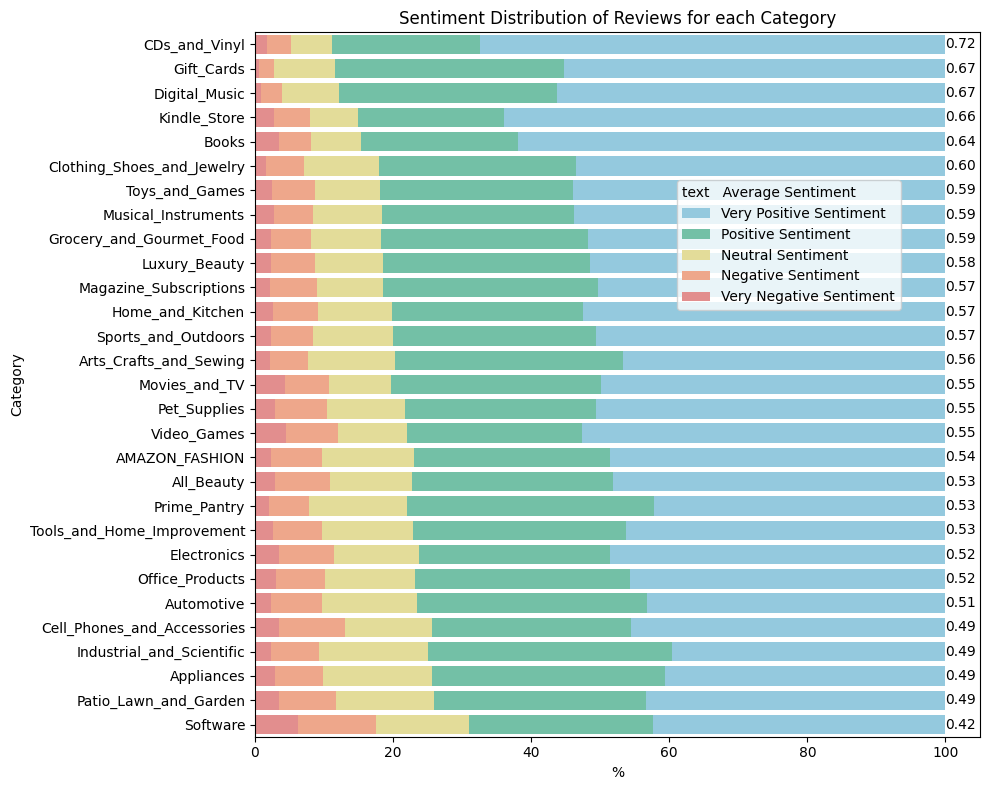

In [9]:
def plot_cat_sentiment(df_cat_sentiment):
    # Calculate comulative values
    com_df_cat_sentiment = df_cat_sentiment.copy()
    sentiments = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    for i in range(0, 4):
        com_df_cat_sentiment[sentiments[i+1]] += com_df_cat_sentiment[sentiments[i]]
    # Normalize and convert to Percent
    for i in range(0, 5):
        com_df_cat_sentiment[sentiments[i]] *= 100 / com_df_cat_sentiment[sentiments[4]]


    com_df_cat_sentiment = com_df_cat_sentiment.sort_values(by=['average_sentiment'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='very_positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[0], label='Very Positive Sentiment')
    sns.barplot(x='positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[1], label='Positive Sentiment')
    sns.barplot(x='neutral', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[2], label='Neutral Sentiment')
    sns.barplot(x='negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[3], label='Negative Sentiment')
    sns.barplot(x='very_negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[4], label='Very Negative Sentiment')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_sentiment.iterrows():
        ax1.text(row['very_positive'], i, f'{row["average_sentiment"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title('Sentiment Distribution of Reviews for each Category')

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text   Average Sentiment', alignment='left')


    # Show the plot
    plt.show()

plot_cat_sentiment(data_cat_sentiment)
# plot_cat_sentiment(ver_cat_sentiment)
# plot_cat_sentiment(notver_cat_sentiment)

In [10]:
print(data_sample.shape)

(2308533, 6)
